#Sketch RNN for Sequential Image Generation

Importing all the libraries

In [ ]:
# ========= INSTALLS (Run this cell first in Colab) =========
!pip install quickdraw imageio numpy torch matplotlib

# ========= IMPORTS =========
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
import random
import math
import time
import quickdraw # Base import
from quickdraw import QuickDrawData # Specific class import
import itertools # For handling generators
import warnings
import imageio

# Suppress quickdraw warnings (optional)
warnings.filterwarnings("ignore", category=UserWarning, module='quickdraw.api')
# Suppress Matplotlib animation warnings if they appear (might still occur from backend)
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Defining the parameters and classes for the model

In [ ]:
# ========= CONFIGURATION =========
class Config:
    # Data parameters
    SELECTED_CLASSES = ["apple", "candle", "cloud", "bicycle", "cake",
                        "clock", "grapes", "fish", "car", "star"]
    MAX_SAMPLES_PER_CLASS = 1000 # Use fewer samples for faster testing, increase later
    MAX_SEQ_LENGTH = 200 # Maximum number of points in a sketch sequence
    DATA_DIR = "./quickdraw_data" # Directory to store downloaded data

    # Model parameters
    EMBEDDING_DIM = 64
    HIDDEN_DIM = 512
    NUM_LSTM_LAYERS = 2
    DROPOUT_RATE = 0.3
    INPUT_DIM = 5 # dx, dy, p1, p2, p3 (pen states: down, up, end)
    OUTPUT_DIM = 5 # Same as input

    # Training parameters
    BATCH_SIZE = 128
    NUM_EPOCHS = 30 # Adjust as needed, start lower for testing
    LEARNING_RATE = 0.001
    CLIP_GRAD_NORM = 1.0
    TEACHER_FORCING_RATIO = 0.7 # Start with higher teacher forcing
    LR_SCHEDULER_FACTOR = 0.5
    LR_SCHEDULER_PATIENCE = 3
    EARLY_STOPPING_PATIENCE = 5
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluation & Visualization
    GENERATION_SEQ_LENGTH = 200 # Max length for generated sequences
    GENERATION_TEMPERATURE = 0.3 # Controls randomness (lower = less random)
    NUM_GENERATION_SAMPLES = 3 # Number of samples to generate per class for eval
    GRID_SIZE = (4, 5) # Rows, Cols for the stroke grid visualization

    # Files
    MODEL_SAVE_PATH = "sketch_generator_model.pth"
    STATS_SAVE_PATH = "data_stats.npz"

config = Config()

# Ensure data directory exists
os.makedirs(config.DATA_DIR, exist_ok=True)

##Data PreProcessing

Downloading the dataset

In [ ]:
# ========= DATA PREPROCESSING FUNCTIONS =========

def download_quickdraw_data(classes, max_drawings, data_dir):
    """Downloads Quick, Draw! data for specified classes."""
    print("Downloading Quick, Draw! data...")
    qd = QuickDrawData(cache_dir=data_dir)
    data = {}
    for class_name in classes:
        try:
            print(f"  Downloading {class_name}...")
            qd_class = qd.get_drawing_group(class_name)
            valid_drawings = []
            if qd_class and hasattr(qd_class, 'drawings'):
                drawings_iterator = qd_class.drawings
                drawings_to_process = itertools.islice(drawings_iterator, max_drawings) if max_drawings is not None else drawings_iterator
                count = 0
                for d in drawings_to_process:
                    if hasattr(d, 'image_data') and d.image_data and len(d.image_data) > 0:
                        if all(isinstance(stroke, (list, tuple)) and len(stroke) >= 2 and stroke[0] for stroke in d.image_data):
                            valid_drawings.append(d)
                            count += 1
                print(f"    Got {count} valid drawings for {class_name}.")
                if valid_drawings: data[class_name] = valid_drawings
                elif count == 0: print(f"    Warning: No valid drawings passed filtering for {class_name}.")
            else: print(f"    Warning: No drawings attribute/returned for {class_name}.")
        except Exception as e:
            print(f"  Error downloading/processing {class_name}: {e}")
            import traceback; traceback.print_exc()
    print("Download complete.")
    return data

Converting strokes to sequence

In [ ]:
def strokes_to_sequence(strokes, max_len):
    """Converts Quick, Draw! strokes into a sequence of (dx, dy, p1, p2, p3)."""
    sequence = []
    last_x, last_y = 0, 0
    for stroke in strokes.image_data:
        if not stroke or not isinstance(stroke, (list, tuple)) or len(stroke) < 2 or not stroke[0]: continue
        x_coords, y_coords = stroke
        if not x_coords: continue
        dx = x_coords[0] - last_x; dy = y_coords[0] - last_y
        sequence.append([dx, dy, 1, 0, 0]); last_x, last_y = x_coords[0], y_coords[0]
        for i in range(1, len(x_coords)):
            if len(sequence) >= max_len -1: break
            dx = x_coords[i] - last_x; dy = y_coords[i] - last_y
            sequence.append([dx, dy, 1, 0, 0]); last_x, last_y = x_coords[i], y_coords[i]
        if len(sequence) >= max_len -1: break
        sequence.append([0, 0, 0, 1, 0]) # Pen up
    if not sequence: return None
    if sequence[-1][3] == 1: sequence[-1] = [0, 0, 0, 0, 1] # Replace last pen up with end
    elif len(sequence) < max_len: sequence.append([0, 0, 0, 0, 1]) # Append end
    else: sequence[-1] = [0, 0, 0, 0, 1] # Replace last point with end
    return np.array(sequence[:max_len], dtype=np.float32)


Function for preprocessing the data

In [ ]:
def preprocess_data(data, max_len):
    """Preprocesses the raw Quick, Draw! data."""
    processed_data = []
    if not data: print("Warning: Input data for preprocessing is empty."); return [], {}, {}
    class_map = {name: i for i, name in enumerate(data.keys())}
    inv_class_map = {i: name for name, i in class_map.items()}
    all_sequences = []
    print("Preprocessing sequences...")
    for class_name, drawings in data.items():
        if not drawings: print(f"  Skipping preprocessing for {class_name}."); continue
        class_idx = class_map[class_name]; count = 0; skipped = 0
        for drawing in drawings:
            sequence = strokes_to_sequence(drawing, max_len)
            if sequence is not None and len(sequence) > 1:
                processed_data.append({'sequence': sequence, 'class_idx': class_idx, 'class_name': class_name, 'length': len(sequence)})
                all_sequences.append(sequence[:, :2]); count += 1
            else: skipped +=1
        print(f"  Processed {count} valid sequences for {class_name} (skipped {skipped})")
    if not processed_data: print("Warning: No valid sequences found after preprocessing.")
    print(f"Total processed sequences: {len(processed_data)}")
    return processed_data, class_map, inv_class_map


Function for Calculation of statistics

In [ ]:
def calculate_stats(sequences):
    """ Calculate mean and std dev for dx, dy """
    valid_sequences = [seq[:, :2] for seq in sequences if seq is not None and seq.shape[0] > 0 and seq.ndim >= 2 and seq.shape[1] >= 2]
    if not valid_sequences: print("Warning: No valid data for stats."); return np.array([0.0, 0.0]), np.array([1.0, 1.0])
    all_deltas = np.concatenate(valid_sequences, axis=0)
    if all_deltas.size == 0: print("Warning: Empty delta array for stats."); return np.array([0.0, 0.0]), np.array([1.0, 1.0])
    mean = np.mean(all_deltas, axis=0); std = np.std(all_deltas, axis=0)
    std = np.where(std < 1e-6, 1e-6, std)
    return mean, std

Normalising the sequences

In [ ]:
def normalize_sequence(sequence, mean, std):
    """Normalize dx, dy using pre-calculated stats."""
    if sequence is None: return None
    sequence[:, :2] = (sequence[:, :2] - mean) / std
    return sequence

Denormalising the sequence

In [ ]:
def denormalize_sequence(sequence, mean, std):
    """Denormalize dx, dy using pre-calculated stats."""
    if isinstance(sequence, torch.Tensor): sequence = sequence.cpu().numpy()
    if sequence is None or sequence.size == 0: return sequence
    sequence_copy = sequence.copy()
    if sequence_copy.ndim >= 1 and sequence_copy.shape[-1] >= 2:
        sequence_copy[..., :2] = sequence_copy[..., :2] * std + mean
    else: print(f"Warning: Unexpected shape for denormalization: {sequence_copy.shape}")
    return sequence_copy

Load the data

In [ ]:
# ========= DATASET AND DATALOADER =========

class QuickDrawDataset(Dataset):
    """PyTorch Dataset for Quick, Draw! sequences."""
    def __init__(self, data, data_mean, data_std, normalize=True):
        self.data = data; self.mean = data_mean; self.std = data_std
        self.normalize = normalize; self.dummy_item = None
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        try:
            item = self.data[idx]; sequence = item['sequence'].copy()
            original_length = item['length']; class_idx_val = item['class_idx']
            if self.normalize:
                sequence = normalize_sequence(sequence, self.mean, self.std)
                if sequence is None: raise ValueError(f"Normalization returned None idx {idx}")
            sos_token = np.array([[0., 0., 1., 0., 0.]], dtype=np.float32)
            input_sequence = np.vstack([sos_token, sequence[:-1, :]])
            target_sequence = sequence
            return {'input_sequence': torch.tensor(input_sequence, dtype=torch.float32),
                    'target_sequence': torch.tensor(target_sequence, dtype=torch.float32),
                    'class_idx': torch.tensor(class_idx_val, dtype=torch.long),
                    'length': torch.tensor(original_length, dtype=torch.long)}
        except Exception as e:
             print(f"Error loading item {idx}: {e}. Returning dummy.")
             if self.dummy_item is None:
                 dummy_len = 2
                 self.dummy_item = {'input_sequence': torch.zeros((dummy_len, config.INPUT_DIM), dtype=torch.float32),
                                    'target_sequence': torch.zeros((dummy_len, config.OUTPUT_DIM), dtype=torch.float32),
                                    'class_idx': torch.tensor(-1, dtype=torch.long), 'length': torch.tensor(0, dtype=torch.long)}
             return self.dummy_item

def collate_fn(batch):
    """Pads sequences in a batch and packs them."""
    valid_batch = [item for item in batch if item is not None and item['length'] > 0]
    if not valid_batch: return None
    valid_batch.sort(key=lambda x: x['length'], reverse=True)
    input_sequences = [item['input_sequence'] for item in valid_batch]
    target_sequences = [item['target_sequence'] for item in valid_batch]
    lengths = torch.tensor([item['length'] for item in valid_batch], dtype=torch.long)
    class_indices = torch.stack([item['class_idx'] for item in valid_batch])
    try:
        padded_inputs = nn.utils.rnn.pad_sequence(input_sequences, batch_first=True, padding_value=0.0)
        padded_targets = nn.utils.rnn.pad_sequence(target_sequences, batch_first=True, padding_value=0.0)
    except Exception as e: print(f"Error padding: {e}"); return None
    return {'padded_inputs': padded_inputs, 'padded_targets': padded_targets,
            'lengths': lengths, 'class_indices': class_indices}

##Model architecture

Defining the architecture of the model

In [ ]:
# ========= MODEL ARCHITECTURE =========
class SketchRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_classes, embedding_dim, num_layers, dropout):
        super(SketchRNN, self).__init__()
        self.hidden_dim = hidden_dim; self.num_layers = num_layers
        self.class_embedding = nn.Embedding(num_classes, embedding_dim)
        self.lstm = nn.LSTM(input_dim + embedding_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc_output = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, lengths, class_idx, hidden=None):
        batch_size, seq_len, _ = x.size()
        class_emb = self.class_embedding(class_idx)
        class_emb_expanded = class_emb.unsqueeze(1).expand(-1, seq_len, -1)
        lstm_input = self.dropout(torch.cat((x, class_emb_expanded), dim=2))
        lengths_cpu = lengths.cpu().clamp(min=1)
        if torch.any(lengths_cpu <= 0): raise ValueError(f"Invalid lengths for packing: {lengths_cpu.tolist()}")
        packed_input = pack_padded_sequence(lstm_input, lengths_cpu, batch_first=True, enforce_sorted=True)
        packed_output, hidden = self.lstm(packed_input, hidden)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        current_max_len = output.size(1)
        if current_max_len < seq_len:
            padding = torch.zeros(batch_size, seq_len - current_max_len, self.hidden_dim, device=output.device, dtype=output.dtype)
            output = torch.cat([output, padding], dim=1)
        output = self.fc_output(self.dropout(output))
        return output, hidden
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_dim).to(config.DEVICE),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_dim).to(config.DEVICE))

Defining the loss function for the model

In [ ]:
# ========= LOSS FUNCTION =========
def sketch_rnn_loss(outputs, targets, lengths):
    """Custom loss function for SketchRNN. Uses lengths for masking."""
    batch_size, seq_len, _ = outputs.shape
    lengths = lengths.to(outputs.device) # Ensure lengths are on correct device
    pred_dxdy = outputs[:, :, 0:2]; target_dxdy = targets[:, :, 0:2]
    pred_pen_logits = outputs[:, :, 2:5]; target_pen_indices = torch.argmax(targets[:, :, 2:5], dim=-1)
    loss_mse = nn.functional.mse_loss(pred_dxdy, target_dxdy, reduction='none').sum(dim=-1)
    loss_ce = nn.functional.cross_entropy(pred_pen_logits.reshape(-1, 3), target_pen_indices.reshape(-1), reduction='none').reshape(batch_size, seq_len)
    mask = (torch.arange(seq_len, device=outputs.device)[None, :] < lengths[:, None]).float()
    valid_steps = mask.sum(dim=1).clamp(min=1)
    masked_loss_mse = (loss_mse * mask).sum(dim=1) / valid_steps
    masked_loss_ce = (loss_ce * mask).sum(dim=1) / valid_steps
    total_loss = masked_loss_mse.mean() + masked_loss_ce.mean()
    if torch.isnan(total_loss) or torch.isinf(total_loss):
        print("NaN/Inf Loss Detected!"); return torch.tensor(0.0, device=outputs.device, requires_grad=True) # Return 0 loss to try continuing
    return total_loss

## Training the model

Function for training the model for a single epoch

In [ ]:
# ========= TRAINING AND EVALUATION FUNCTIONS =========
def train_epoch(model, dataloader, optimizer, criterion, clip_norm, device, teacher_forcing_ratio):
    model.train(); epoch_loss = 0.0; num_batches = len(dataloader); batches_processed = 0
    for i, batch in enumerate(dataloader):
        if batch is None: continue
        padded_inputs = batch['padded_inputs'].to(device); padded_targets = batch['padded_targets'].to(device)
        lengths = batch['lengths']; class_indices = batch['class_indices'].to(device)
        if torch.any(lengths <= 0): print(f"Skip train batch {i+1} invalid lengths"); continue
        optimizer.zero_grad()
        try:
            outputs, _ = model(padded_inputs, lengths.cpu(), class_indices) # lengths CPU for pack
            loss = criterion(outputs, padded_targets, lengths.to(device)) # lengths GPU for mask
            if torch.isnan(loss) or torch.isinf(loss): print(f"Skip train batch {i+1} NaN/Inf loss"); continue
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm); optimizer.step()
            epoch_loss += loss.item(); batches_processed += 1
        except Exception as e: print(f"Error train batch {i+1}: {e}"); import traceback; traceback.print_exc(); continue
        if batches_processed > 0 and (i + 1) % 50 == 0: print(f"  Batch ~{i+1}/{num_batches}, Loss: {loss.item():.4f}")
    if batches_processed == 0: print("Warning: No batches processed train epoch."); return float('nan')
    return epoch_loss / batches_processed

Function for evaluation of model for a single epoch

In [ ]:
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval(); epoch_loss = 0.0; num_batches = len(dataloader); batches_processed = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if batch is None: continue
            padded_inputs = batch['padded_inputs'].to(device); padded_targets = batch['padded_targets'].to(device)
            lengths = batch['lengths']; class_indices = batch['class_indices'].to(device)
            if torch.any(lengths <= 0): print(f"Skip eval batch {i+1} invalid lengths"); continue
            try:
                outputs, _ = model(padded_inputs, lengths.cpu(), class_indices)
                loss = criterion(outputs, padded_targets, lengths.to(device))
                if torch.isnan(loss) or torch.isinf(loss): print(f"Skip eval batch {i+1} NaN/Inf loss"); continue
                epoch_loss += loss.item(); batches_processed += 1
            except Exception as e: print(f"Error eval batch {i+1}: {e}"); continue
    if batches_processed == 0: print("Warning: No batches processed eval epoch."); return float('nan')
    return epoch_loss / batches_processed

Training the entire model

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, clip_norm, early_stop_p, save_path, device):
    best_val_loss = float('inf'); epochs_no_improve = 0; history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip_norm, device, config.TEACHER_FORCING_RATIO)
        val_loss = evaluate_epoch(model, val_loader, criterion, device)
        epoch_duration = time.time() - start_time
        train_loss_str = f"{train_loss:.4f}" if not math.isnan(train_loss) else "NaN"
        val_loss_str = f"{val_loss:.4f}" if not math.isnan(val_loss) else "NaN"
        print(f"Epoch {epoch+1}/{num_epochs} | Duration: {epoch_duration:.2f}s | Train Loss: {train_loss_str} | Val Loss: {val_loss_str}")
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        if not math.isnan(val_loss):
            current_lr = optimizer.param_groups[0]['lr']; scheduler.step(val_loss); new_lr = optimizer.param_groups[0]['lr']
            if new_lr < current_lr: print(f"  LR reduced to {new_lr:.6f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss; torch.save(model.state_dict(), save_path); print(f"  Val loss improved. Saved model."); epochs_no_improve = 0
            else:
                epochs_no_improve += 1; print(f"  Val loss didn't improve {epochs_no_improve} epoch(s).")
                if epochs_no_improve >= early_stop_p: print(f"Early stopping."); break
        else: print("  Skipping LR schedule/early stop due to NaN val loss.")
    print("Training finished.")
    if os.path.exists(save_path):
        try: model.load_state_dict(torch.load(save_path)); best_loss_str = f"{best_val_loss:.4f}" if best_val_loss!=float('inf') else "N/A"; print(f"Loaded best model (Val loss: {best_loss_str})")
        except Exception as e: print(f"Error loading best model: {e}")
    else: print(f"Warning: Model file not found.")
    return model, history

## Visualisation and analysis

In [ ]:
# ========= VISUALIZATION FUNCTIONS (No GIF) =========

def plot_sketch(sequence, title="Sketch", ax=None, cumulative=True, line_color='black', line_width=2):
    """Plots a sketch sequence (dx, dy, p1, p2, p3). Clears axis first."""
    standalone_plot = ax is None
    if standalone_plot: fig, ax = plt.subplots(figsize=(5, 5))
    ax.clear() # Ensure axis is clean before plotting
    if sequence is None or len(sequence) == 0:
        ax.set_title(f"{title} (Empty)"); ax.set_xticks([]); ax.set_yticks([])
        return
    if isinstance(sequence, torch.Tensor): sequence = sequence.cpu().numpy()
    coords = np.cumsum(sequence[:, :2], axis=0); coords = np.insert(coords, 0, [0, 0], axis=0)
    ax.set_title(title); ax.set_aspect('equal', adjustable='box'); ax.set_xticks([]); ax.set_yticks([])
    for i in range(len(sequence)):
        if sequence[i, 2] == 1: # Pen down
            ax.plot([coords[i,0], coords[i+1,0]], [coords[i,1], coords[i+1,1]],
                    color=line_color, linewidth=line_width, solid_capstyle='round')
    if coords.shape[0] > 1:
        min_x, min_y = np.min(coords, axis=0)-10; max_x, max_y = np.max(coords, axis=0)+10
        if abs(min_x - max_x) < 1e-6: max_x = min_x + 1
        if abs(min_y - max_y) < 1e-6: max_y = min_y + 1
        ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y)
    else: ax.set_xlim(-10, 10); ax.set_ylim(-10, 10)
    ax.invert_yaxis()

def plot_stroke_grid(sequence, filename="grid.png", title="Stroke Grid", grid_size=(4, 5)):
    """Plots snapshots of sketch generation on a grid."""
    if sequence is None or len(sequence)==0: print("Cannot plot grid, empty seq."); return
    rows, cols = grid_size; num_frames = rows*cols; total_steps = len(sequence)
    if total_steps <= 1: steps_to_show = np.array([1]) if total_steps==1 else np.array([])
    elif total_steps <= num_frames: steps_to_show = np.arange(1, total_steps + 1)
    else:
        indices = np.linspace(0, total_steps - 1, num_frames, dtype=int); steps_to_show = indices + 1
        steps_to_show = np.unique(steps_to_show)
        if 1 not in steps_to_show and len(steps_to_show)<num_frames: steps_to_show=np.insert(steps_to_show,0,1)
        if total_steps not in steps_to_show:
            if len(steps_to_show)>=num_frames: steps_to_show[-1]=total_steps
            else: steps_to_show=np.append(steps_to_show,total_steps)
        steps_to_show = np.unique(steps_to_show)[:num_frames]
    print(f"Plotting grid {len(steps_to_show)} frames for seq len {total_steps}.")
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3), squeeze=False); fig.suptitle(title, fontsize=16, y=1.02)
    ax_flat = axes.flatten()
    for i, step_num in enumerate(steps_to_show):
        if i >= len(ax_flat): break
        plot_sketch(sequence[:step_num], title=f"Step {step_num}", ax=ax_flat[i]) # Use plot_sketch on specific axis
    for j in range(len(steps_to_show), len(ax_flat)): ax_flat[j].set_visible(False)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]); fig.savefig(filename); print(f"Saved grid: {filename}"); plt.close(fig)



Function for generating the sketch

In [ ]:
# ========= GENERATION FUNCTION =========
def generate_sketch(model, class_idx, class_map, inv_class_map, data_mean, data_std, max_len=config.GENERATION_SEQ_LENGTH, temperature=config.GENERATION_TEMPERATURE, device=config.DEVICE):
    """Generates a sketch sequence for a given class index."""
    model.eval(); class_name = inv_class_map.get(class_idx, f"Unknown ({class_idx})"); print(f"Generating: {class_name}")
    current_stroke = torch.tensor([[0., 0., 1., 0., 0.]], dtype=torch.float32).to(device)
    class_tensor = torch.tensor([class_idx], dtype=torch.long).to(device); hidden = model.init_hidden(1)
    gen_seq_norm = [];
    with torch.no_grad():
        for i in range(max_len):
            input_stroke = current_stroke.unsqueeze(1); lengths = torch.tensor([1]).cpu()
            try: output, hidden = model(input_stroke, lengths, class_tensor, hidden)
            except Exception as e: print(f"  Error gen step {i+1}: {e}"); break
            output = output.squeeze(1)
            if torch.isnan(output).any() or torch.isinf(output).any(): print(f"  NaN/Inf output step {i+1}"); break
            pred_dxdy = output[:, 0:2]; pred_pen_logits = output[:, 2:5]
            safe_temp = max(temperature, 1e-6); scaled_logits = pred_pen_logits / safe_temp
            pen_probs = torch.softmax(scaled_logits, dim=-1)
            try: next_pen_idx = torch.multinomial(pen_probs, 1).item()
            except RuntimeError as e: print(f"  Error sampling step {i+1}: {e}, Probs: {pen_probs.cpu().numpy()}"); break
            next_pen_onehot = torch.zeros(3, device=device); next_pen_onehot[next_pen_idx] = 1.0
            next_stroke = torch.cat([pred_dxdy, next_pen_onehot.unsqueeze(0)], dim=1)
            gen_seq_norm.append(next_stroke.squeeze().cpu().numpy())
            if next_pen_idx == 2: print(f"  End token step {i+1}."); break
            current_stroke = next_stroke
    print(f"  Gen length: {len(gen_seq_norm)}")
    gen_seq_np = np.array(gen_seq_norm)
    if gen_seq_np.size > 0: return denormalize_sequence(gen_seq_np, data_mean, data_std)
    else: print("  Warn: Empty gen sequence."); return None

## Bonus task

In [ ]:
# ========= BONUS TASK FUNCTIONS =========
def interactive_refinement_demo(model, class_name, class_map, inv_class_map, data_mean, data_std, device):
    """ Allows basic interactive refinement via temperature adjustment. """
    if class_name not in class_map: print(f"Class '{class_name}' not found."); return
    class_idx = class_map[class_name]; current_temp = config.GENERATION_TEMPERATURE
    print(f"\n--- Interactive Refinement: {class_name} ---")
    print("Enter new temperature (e.g., 0.2 low random, 0.8 high random) or 'quit'.")
    while True:
        print(f"\nGenerating with temp = {current_temp:.2f}...")
        generated_seq = generate_sketch(model, class_idx, class_map, inv_class_map, data_mean, data_std,
                                        max_len=config.GENERATION_SEQ_LENGTH, temperature=current_temp, device=device)
        if generated_seq is None: print("Failed to generate. Exiting."); break
        try:
            fig_refine, ax_refine = plt.subplots(figsize=(6, 6))
            plot_sketch(generated_seq, title=f"Generated {class_name} (Temp: {current_temp:.2f})", ax=ax_refine)
            plt.show() # Display plot
        except Exception as e: print(f"Error display plot: {e}"); plt.close('all')
        try:
             user_input = input("Enter new temperature or 'quit': ").strip().lower()
        except EOFError: # Handle environments where input isn't available
             print("Input not available, exiting interactive refinement.")
             break

        plt.close('all') # Close plot before next input/generation
        if user_input == 'quit': print("Exiting refinement."); break
        else:
            try: new_temp = float(user_input); current_temp = new_temp if new_temp > 0 else current_temp
            except ValueError: print("Invalid input.")

def multi_object_composition_demo(model, object_names, class_map, inv_class_map, data_mean, data_std, device, spacing=75):
    """ Generates objects sequentially with basic horizontal offset. """
    print(f"\n--- Multi-Object Composition: {', '.join(object_names)} ---")
    all_strokes = []; current_offset_x = 0.0; current_offset_y = 0.0
    output_viz_dir = "output_visualizations"; os.makedirs(output_viz_dir, exist_ok=True)
    valid_obj_names = [] # Store names of objects actually generated

    for i, obj_name in enumerate(object_names):
        print(f"\nGenerating object {i+1}: {obj_name}")
        if obj_name not in class_map: print(f"  Warn: Class '{obj_name}' skip."); continue
        class_idx = class_map[obj_name]
        obj_seq = generate_sketch(model, class_idx, class_map, inv_class_map, data_mean, data_std,
                                  temperature=config.GENERATION_TEMPERATURE, device=device)
        if obj_seq is not None and len(obj_seq) > 0:
            # Apply offset to first delta
            obj_seq[0, 0] += current_offset_x
            obj_seq[0, 1] += current_offset_y
            all_strokes.append(obj_seq)
            valid_obj_names.append(obj_name) # Add name if generated

            # Update offset for next object based on current object's X extent
            total_dx = np.sum(obj_seq[:, 0]) # How much total X movement in this object
            current_offset_x += total_dx + spacing # Move start of next object
            print(f"  Generated {obj_name}. Next offset X: {current_offset_x:.1f}")
        else: print(f"  Failed to generate sequence for {obj_name}.")

    if all_strokes:
        print("\nCombining generated objects...")
        combined_sequence = np.vstack(all_strokes)
        scene_title = f"Composed Scene: {', '.join(valid_obj_names)}"
        try:
            fig_comp, ax_comp = plt.subplots(figsize=(10, 5))
            plot_sketch(combined_sequence, title=scene_title, ax=ax_comp)
            comp_filename = os.path.join(output_viz_dir, f"composed_scene_{'_'.join(valid_obj_names)}.png")
            fig_comp.savefig(comp_filename); print(f"Saved composed scene: {comp_filename}"); plt.show()
        except Exception as e: print(f"Error plotting/saving composed scene: {e}"); plt.close('all')
    else: print("No objects generated for composition.")

##Main function

Device: cuda
Classes: ['apple', 'candle', 'cloud', 'bicycle', 'cake', 'clock', 'grapes', 'fish', 'car', 'star']
downloading apple from https://storage.googleapis.com/quickdraw_dataset/full/binary/apple.bin
download complete
loading apple drawings
load complete
    Got 1000 valid drawings for apple.
downloading candle from https://storage.googleapis.com/quickdraw_dataset/full/binary/candle.bin
download complete
loading candle drawings
load complete
    Got 1000 valid drawings for candle.
downloading cloud from https://storage.googleapis.com/quickdraw_dataset/full/binary/cloud.bin
download complete
loading cloud drawings
load complete
    Got 1000 valid drawings for cloud.
downloading bicycle from https://storage.googleapis.com/quickdraw_dataset/full/binary/bicycle.bin
download complete
loading bicycle drawings
load complete
    Got 1000 valid drawings for bicycle.
downloading cake from https://storage.googleapis.com/quickdraw_dataset/full/binary/cake.bin
download complete
loading cake d

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Batch ~50/54, Loss: 2.0993
Epoch 1/30 | Duration: 8.60s | Train Loss: 2.6378 | Val Loss: 2.1837
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 2.0235
Epoch 2/30 | Duration: 5.98s | Train Loss: 2.1296 | Val Loss: 1.9473
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 1.8439
Epoch 3/30 | Duration: 5.67s | Train Loss: 1.9687 | Val Loss: 1.7959
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 1.9095
Epoch 4/30 | Duration: 5.87s | Train Loss: 1.8676 | Val Loss: 1.6670
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 1.8696
Epoch 5/30 | Duration: 5.70s | Train Loss: 1.7820 | Val Loss: 1.5745
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 1.5617
Epoch 6/30 | Duration: 5.84s | Train Loss: 1.7307 | Val Loss: 1.5209
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 1.7254
Epoch 7/30 | Duration: 5.78s | Train Loss: 1.6980 | Val Loss: 1.5085
  Val loss improved. Saved model.
  Batch ~50/54, Loss: 1.6513
Epoch 8/30 | Duration: 5.84s | Train Loss: 1.66

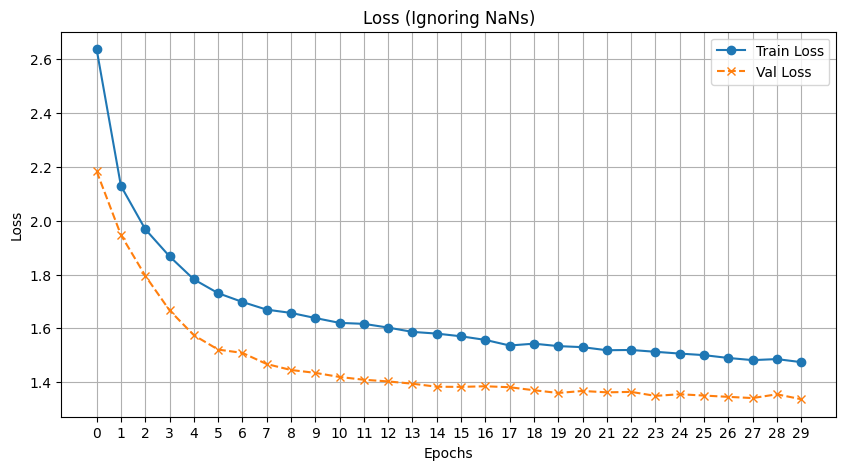


Evaluation & Visualization...
Loaded best model.

Generating 3 samples/class...

--- Class: apple ---
Generating: apple
  Gen length: 200
 Saved plot: output_visualizations/generated_apple_1.png
Plotting grid 20 frames for seq len 200.
Saved grid: output_visualizations/generated_apple_1_grid.png
Generating: apple
  End token step 52.
  Gen length: 52
 Saved plot: output_visualizations/generated_apple_2.png
Plotting grid 20 frames for seq len 52.
Saved grid: output_visualizations/generated_apple_2_grid.png
Generating: apple
  End token step 41.
  Gen length: 41
 Saved plot: output_visualizations/generated_apple_3.png
Plotting grid 20 frames for seq len 41.
Saved grid: output_visualizations/generated_apple_3_grid.png
 Saved real plot: output_visualizations/real_apple_1.png
 Saved real plot: output_visualizations/real_apple_2.png

--- Class: candle ---
Generating: candle
  Gen length: 200
 Saved plot: output_visualizations/generated_candle_1.png
Plotting grid 20 frames for seq len 200.
S

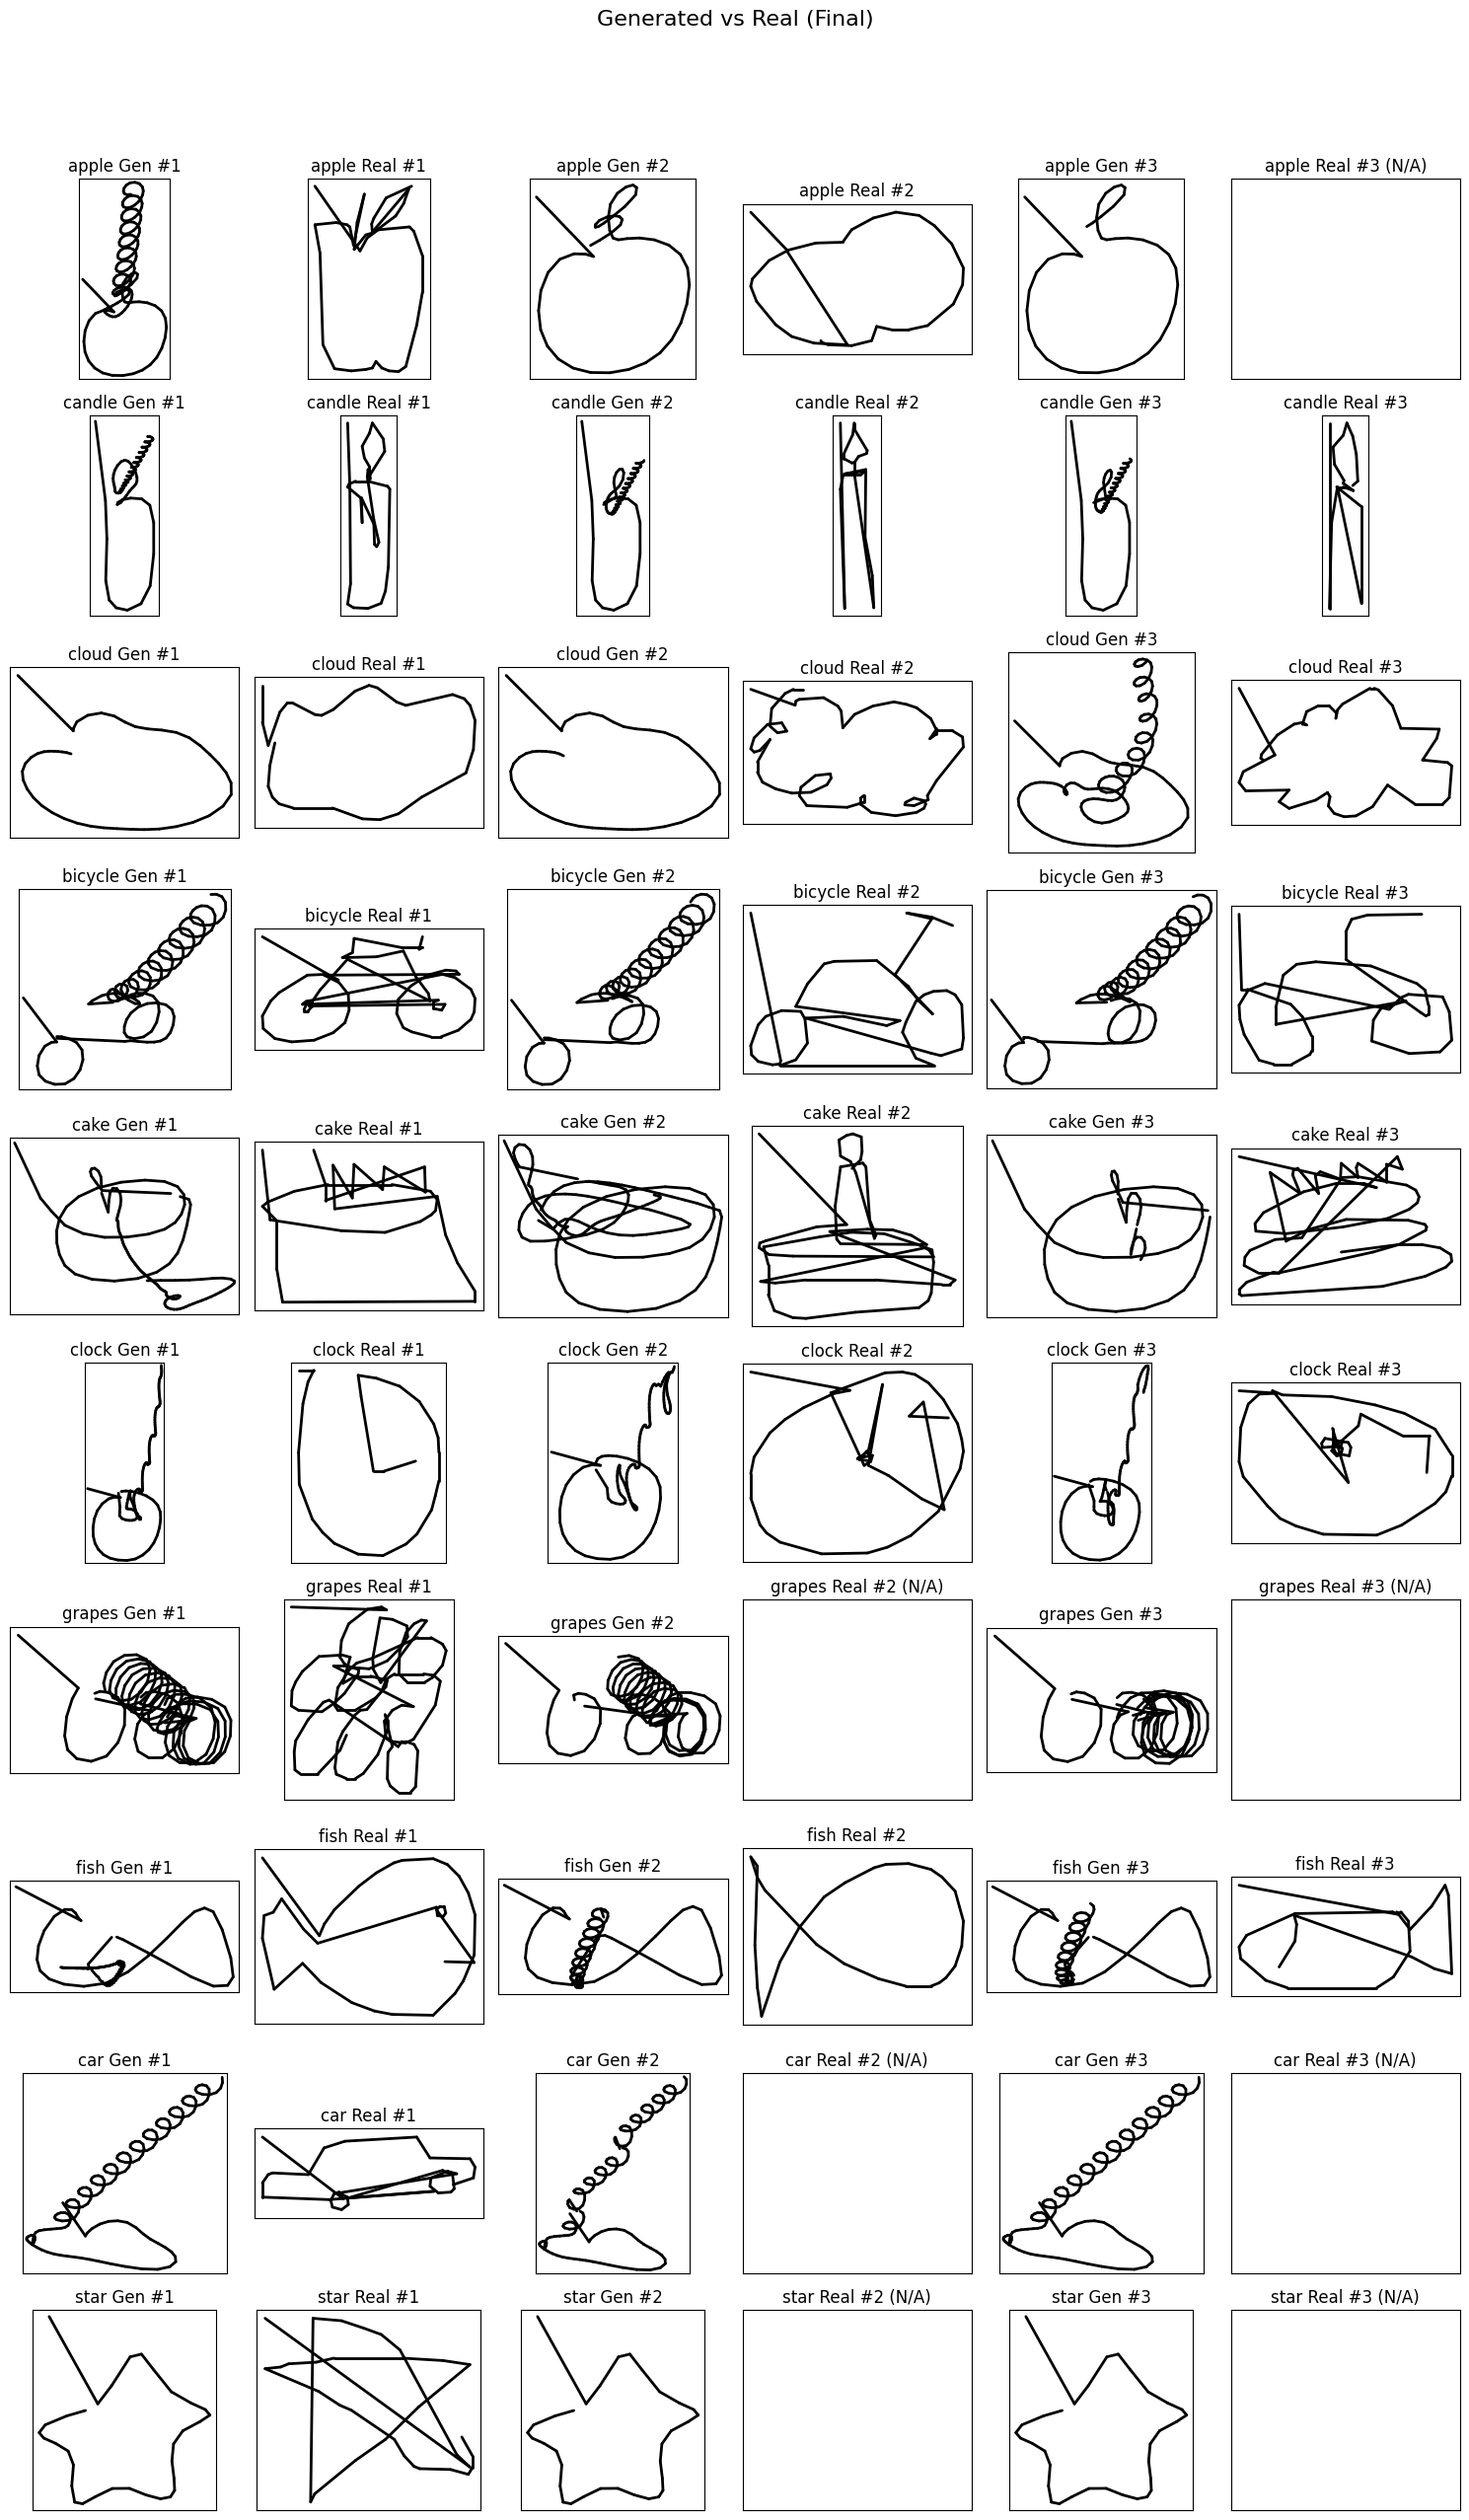


--- Analysis ---
Check plots (_final.png) and grids (_grid.png) in 'output_visualizations'.
- Compare generated vs real.
- Observe stroke-by-stroke visuals in grids.
- Note successes/failures.
- Consider temperature/class effects.

--- Running Bonus Task Demos ---

--- Interactive Refinement: apple ---
Enter new temperature (e.g., 0.2 low random, 0.8 high random) or 'quit'.

Generating with temp = 0.30...
Generating: apple
  End token step 55.
  Gen length: 55


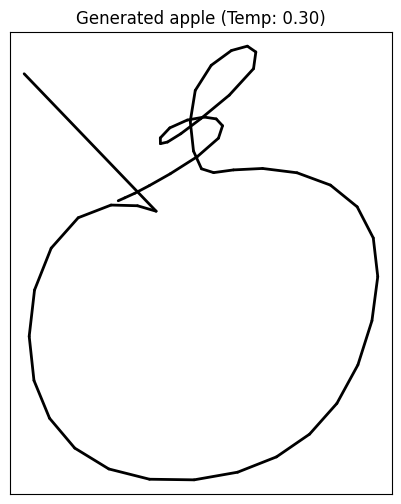

Enter new temperature or 'quit': quit
Exiting refinement.

--- Multi-Object Composition: cake, apple ---

Generating object 1: cake
Generating: cake
  Gen length: 200
  Generated cake. Next offset X: -33.7

Generating object 2: apple
Generating: apple
  End token step 40.
  Gen length: 40
  Generated apple. Next offset X: 108.9

Combining generated objects...
Saved composed scene: output_visualizations/composed_scene_cake_apple.png


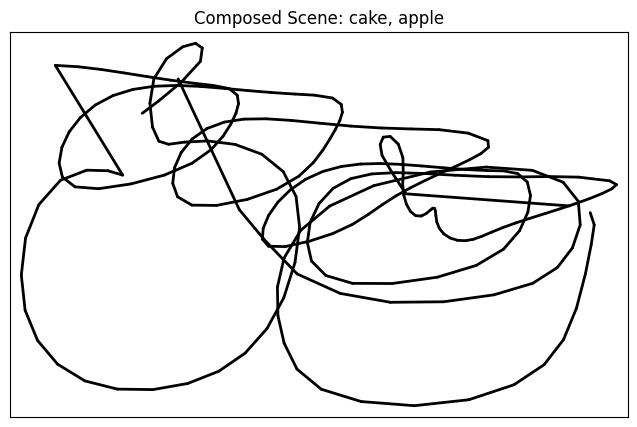

In [ ]:
# ========= MAIN EXECUTION =========
if __name__ == "__main__":

    can_proceed = False # Flag to control execution flow
    processed_data = None
    train_dataset, val_dataset, test_dataset = None, None, None
    data_mean, data_std = None, None
    class_map, inv_class_map = {}, {}
    model = None # Initialize model variable

    print(f"Device: {config.DEVICE}"); print(f"Classes: {config.SELECTED_CLASSES}")
    # --- 1. Load/Preprocess ---
    try:
        raw_data = download_quickdraw_data(config.SELECTED_CLASSES, config.MAX_SAMPLES_PER_CLASS, config.DATA_DIR)
        if raw_data: processed_data, class_map, inv_class_map = preprocess_data(raw_data, config.MAX_SEQ_LENGTH)
        if processed_data: can_proceed = True
        else: print("Error: No data after preprocessing.")
    except Exception as data_err: print(f"Data Error: {data_err}"); import traceback; traceback.print_exc()
    # --- 2. Split/Stats/Datasets ---
    if can_proceed:
        try:
            total_samples = len(processed_data)
            if total_samples < 3: print(f"Error: Too few samples ({total_samples})"); can_proceed = False
            else:
                train_size = int(0.7*total_samples); val_size = int(0.15*total_samples)
                if train_size>0 and val_size==0 and total_samples>train_size: val_size=1
                test_size = total_samples-train_size-val_size
                if test_size<=0 and total_samples>train_size+val_size: test_size=1; train_size=total_samples-val_size-test_size
                if train_size<=0 or val_size<=0 or test_size<=0: print(f"Error: Invalid split T:{train_size},V:{val_size},T:{test_size}"); can_proceed = False
                else:
                    print(f"\nSplit: Total={total_samples}, Train={train_size}, Val={val_size}, Test={test_size}")
                    random.shuffle(processed_data); train_data_raw=processed_data[:train_size]; val_data_raw=processed_data[train_size:train_size+val_size]; test_data_raw=processed_data[train_size+val_size:]
                    # Stats
                    train_seqs = [item['sequence'] for item in train_data_raw]
                    if os.path.exists(config.STATS_SAVE_PATH):
                         try: stats=np.load(config.STATS_SAVE_PATH); data_mean,data_std=stats['mean'],stats['std']; print("Loaded stats.")
                         except Exception as e_stat: print(f"Error loading stats: {e_stat}, recalculating..."); data_mean,data_std=calculate_stats(train_seqs)
                    else: data_mean,data_std=calculate_stats(train_seqs); print("Calculated stats.")
                    # Save only if valid
                    if not (np.isnan(data_mean).any() or np.isnan(data_std).any()): np.savez(config.STATS_SAVE_PATH, mean=data_mean, std=data_std); print("Saved stats.")
                    else: print("Warn: NaN stats, not saved.")

                    print(f"Mean: {data_mean}, Std: {data_std}")
                    if np.isnan(data_mean).any() or np.isnan(data_std).any(): print("Error: Invalid stats."); can_proceed = False
                    else: # Datasets
                        train_dataset=QuickDrawDataset(train_data_raw,data_mean,data_std); val_dataset=QuickDrawDataset(val_data_raw,data_mean,data_std); test_dataset=QuickDrawDataset(test_data_raw,data_mean,data_std)
                        print(f"Datasets: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
                        if len(train_dataset)==0 or len(val_dataset)==0: print("Error: Empty train/val dataset."); can_proceed = False
        except Exception as split_err: print(f"Split/Stats/Dataset Error: {split_err}"); import traceback; traceback.print_exc(); can_proceed = False
    # --- Training & Eval Block ---
    if can_proceed:
        train_loader=DataLoader(train_dataset, config.BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory='cuda'==config.DEVICE.type, num_workers=2 if 'cuda'==config.DEVICE.type else 0, drop_last=True)
        val_loader=DataLoader(val_dataset, config.BATCH_SIZE, shuffle=False, collate_fn=collate_fn, pin_memory='cuda'==config.DEVICE.type, num_workers=2 if 'cuda'==config.DEVICE.type else 0)
        test_loader=DataLoader(test_dataset, 64, shuffle=False, collate_fn=collate_fn)
        # --- 5. Initialize ---
        num_classes = len(config.SELECTED_CLASSES)
        model = SketchRNN(config.INPUT_DIM, config.HIDDEN_DIM, config.OUTPUT_DIM, num_classes, config.EMBEDDING_DIM, config.NUM_LSTM_LAYERS, config.DROPOUT_RATE).to(config.DEVICE)
        print("\nModel:", model); print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
        optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
        criterion = sketch_rnn_loss
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=config.LR_SCHEDULER_FACTOR,patience=config.LR_SCHEDULER_PATIENCE,verbose=True)
        # --- 6. Train ---
        print("\nTraining...")
        model, history = train_model(model,train_loader,val_loader,optimizer,criterion,scheduler,config.NUM_EPOCHS,config.CLIP_GRAD_NORM,config.EARLY_STOPPING_PATIENCE,config.MODEL_SAVE_PATH,config.DEVICE)
        # Plot history
        if history['train_loss'] or history['val_loss']:
            plt.figure(figsize=(10, 5)); epochs_ran = len(history['train_loss'])
            valid_train = [(e, l) for e, l in enumerate(history['train_loss']) if not math.isnan(l)]
            valid_val = [(e, l) for e, l in enumerate(history['val_loss']) if not math.isnan(l)]
            if valid_train: te, tl = zip(*valid_train); plt.plot(te, tl, label='Train Loss', marker='o')
            if valid_val: ve, vl = zip(*valid_val); plt.plot(ve, vl, label='Val Loss', marker='x', linestyle='--')
            plt.title('Loss (Ignoring NaNs)'); plt.xlabel('Epochs'); plt.ylabel('Loss')
            if valid_train or valid_val: plt.legend(); plt.grid(True)
            if epochs_ran>0: plt.xticks(range(epochs_ran))
            plt.savefig("training_loss_plot.png"); print("Saved loss plot."); plt.show()
        else: print("No training history.")
        # --- 7. Evaluation & Viz ---
        print("\nEvaluation & Visualization...")
        model_loaded = os.path.exists(config.MODEL_SAVE_PATH)
        if model_loaded:
            try: model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, map_location=config.DEVICE)); model.eval(); print("Loaded best model.")
            except Exception as e: print(f"Error loading best model: {e}"); model_loaded=False
        if model_loaded:
            k_real = min(config.NUM_GENERATION_SAMPLES * num_classes, len(test_dataset)) if len(test_dataset)>0 else 0
            real_samples = [test_dataset[i] for i in random.sample(range(len(test_dataset)), k=k_real)] if k_real>0 else []
            output_dir = "output_visualizations"; os.makedirs(output_dir, exist_ok=True)
            print(f"\nGenerating {config.NUM_GENERATION_SAMPLES} samples/class...")
            gen_results = {}
            for class_idx, class_name in inv_class_map.items():
                print(f"\n--- Class: {class_name} ---"); gen_results[class_name] = {'generated': [], 'real': []}
                for i in range(config.NUM_GENERATION_SAMPLES):
                    gen_seq = generate_sketch(model,class_idx,class_map,inv_class_map,data_mean,data_std,device=config.DEVICE)
                    if gen_seq is not None:
                        gen_results[class_name]['generated'].append(gen_seq)
                        base_fname = f"generated_{class_name}_{i+1}"; plot_f=os.path.join(output_dir,f"{base_fname}.png")
                        grid_f=os.path.join(output_dir,f"{base_fname}_grid.png"); # Removed gif_f

                        # Save final plot
                        try: fig_p,ax_p=plt.subplots(figsize=(5,5)); plot_sketch(gen_seq,f"{base_fname} (Final)",ax=ax_p); fig_p.savefig(plot_f); plt.close(fig_p); print(f" Saved plot: {plot_f}")
                        except Exception as e: print(f" Err plot: {e}"); plt.close('all')

                        # Save grid plot
                        try: plot_stroke_grid(gen_seq, grid_f, f"{base_fname} Steps", config.GRID_SIZE)
                        except Exception as e: print(f" Err grid: {e}"); plt.close('all')

                        # Removed GIF creation/display call

                # Real examples plot
                real_cnt = 0
                for sample in real_samples:
                    if sample is None or sample['length']<=0: continue
                    if sample['class_idx'].item()==class_idx and real_cnt<config.NUM_GENERATION_SAMPLES:
                        real_seq=denormalize_sequence(sample['target_sequence'].cpu().numpy(), data_mean, data_std); gen_results[class_name]['real'].append(real_seq)
                        real_f=os.path.join(output_dir, f"real_{class_name}_{real_cnt+1}.png")
                        try: fig_r,ax_r=plt.subplots(figsize=(5,5)); plot_sketch(real_seq,f"Real {class_name} #{real_cnt+1}",ax=ax_r); fig_r.savefig(real_f); plt.close(fig_r); print(f" Saved real plot: {real_f}")
                        except Exception as e: print(f" Err real plot: {e}"); plt.close('all')
                        real_cnt+=1
                while len(gen_results[class_name]['real']) < config.NUM_GENERATION_SAMPLES: gen_results[class_name]['real'].append(None)

            # --- 8. Final Comparison Grid ---
            print("\nCreating final comparison grid..."); plt.close('all') # Close previous before big grid
            try:
                num_classes_show = len(config.SELECTED_CLASSES); num_cols=config.NUM_GENERATION_SAMPLES*2
                fig_grid, axes_grid = plt.subplots(num_classes_show,num_cols,figsize=(num_cols*2.5, num_classes_show*2.5), squeeze=False)
                fig_grid.suptitle("Generated vs Real (Final)", fontsize=16, y=1.02)
                for i, cname in enumerate(config.SELECTED_CLASSES):
                    if cname not in gen_results or i>=axes_grid.shape[0]: continue
                    gen_list=gen_results[cname]['generated']; real_list=gen_results[cname]['real']
                    for j in range(config.NUM_GENERATION_SAMPLES):
                            col_g,col_r=j*2, j*2+1;
                            if col_r>=axes_grid.shape[1]: continue
                            ax_g=axes_grid[i,col_g]; ax_r=axes_grid[i,col_r]
                            if j<len(gen_list) and gen_list[j] is not None: plot_sketch(gen_list[j],f"{cname} Gen #{j+1}",ax=ax_g)
                            else: ax_g.set_title(f"{cname} Gen #{j+1} (N/A)"); ax_g.set_xticks([]); ax_g.set_yticks([])
                            if j<len(real_list) and real_list[j] is not None: plot_sketch(real_list[j],f"{cname} Real #{j+1}",ax=ax_r)
                            else: ax_r.set_title(f"{cname} Real #{j+1} (N/A)"); ax_r.set_xticks([]); ax_r.set_yticks([])
                plt.tight_layout(rect=[0,0,1,0.98]); grid_f=os.path.join(output_dir,"comparison_grid_final.png"); fig_grid.savefig(grid_f); print(f"Saved final grid: {grid_f}"); plt.show()
            except Exception as grid_err: print(f"Error final grid: {grid_err}"); plt.close('all')

            # --- Analysis Text ---
            print("\n--- Analysis ---"); print("Check plots (_final.png) and grids (_grid.png) in 'output_visualizations'."); print("- Compare generated vs real."); print("- Observe stroke-by-stroke visuals in grids."); print("- Note successes/failures."); print("- Consider temperature/class effects.")

            # --- Run Bonus Demos ---
            print("\n--- Running Bonus Task Demos ---")
            plt.close('all') # Close comparison grid before demos

            # 1. Interactive Refinement Demo
            try:
                refine_class = config.SELECTED_CLASSES[0] if config.SELECTED_CLASSES else None
                if refine_class and refine_class in class_map:
                    interactive_refinement_demo(model, refine_class, class_map, inv_class_map, data_mean, data_std, config.DEVICE)
                elif refine_class: print(f"Skipping refinement demo: Class '{refine_class}' not in model.")
                else: print("Skipping refinement demo: No classes selected.")
            except Exception as refine_err: print(f"\nError refinement demo: {refine_err}"); plt.close('all')

            # 2. Multi-Object Composition Demo
            try:
                 compose_objects = ["cake", "apple"] # Example list
                 valid_compose_objects = [name for name in compose_objects if name in class_map]
                 if valid_compose_objects:
                     multi_object_composition_demo(model, valid_compose_objects, class_map, inv_class_map, data_mean, data_std, config.DEVICE, spacing=75)
                 else: print("\nSkipping composition demo: None of requested objects trained.")
            except Exception as compose_err: print(f"\nError composition demo: {compose_err}"); plt.close('all')
            # --- End Bonus Demos ---

        else: print("\nSkipping Eval, Viz, Bonus: Model not loaded.")
    # --- End Training & Eval Block ---
    else: print("\nExecution halted before training due to errors.")